# Customers Classification:

The main goal of this project is to identify the 'good' (pay loans in time) and 'bad' (make late payments or are charged off) borrowers. We classify them using the Gradient boosting method. This method is based on the ensemble method. The advantage of this method is the 'boosting' approach, which means it weights the decision trees based on their importance in classification. As we have a small dataset, I expect that this method gives a fair prediction. 

In [1]:
# Import necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

G:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In the section below, we load the data and delete unnecessary columns. This will reduce noise and also make the calculations faster. 

In [2]:
# Load csv data as a dataframe
df = pd.read_csv('Intermediate_data\Trimmed.csv',
                 parse_dates=['earliest_cr_line', 'issue_d',
                              'last_pymnt_d', 'next_pymnt_d',
                              'last_credit_pull_d'])

df['history'] = (df.issue_d - df.earliest_cr_line).dt.days

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
# Drop unnecessary columns and the columns that leak the
# information. For example, non-zero value in
# 'collection recovery fee' column already mean
# that the loan is default. Also remove some columns that have
# very little or zero predictive power

df.drop(['last_pymnt_amnt', 'collection_recovery_fee',
         'recoveries', 'out_prncp_inv', 'out_prncp',
         'total_rec_prncp', 'int_rate', 'total_pymnt',
         'total_pymnt_inv', 'total_rec_late_fee',
         'total_rec_int', 'emp_title', 'debt_settlement_flag',
         'addr_state', 'purpose', 'delinq_amnt', 'hardship_flag',
         'pymnt_plan', 'collections_12_mths_ex_med',
         'chargeoff_within_12_mths', 'acc_now_delinq',
         'earliest_cr_line', 'issue_d', 'last_pymnt_d',
         'next_pymnt_d', 'last_credit_pull_d'],
        axis=1, inplace=True)

We need to treat the categorical and numerical data separately. We replace categorical data with binary dummies (0 or 1). 

In [4]:
# Some columns are categorical.
# I converted them to categorical dummies (0 or 1)

cate_list = list(df.dtypes[df.dtypes == 'object'].index)

df_cate = df[cate_list]

df_cat_dum = pd.get_dummies(df_cate, drop_first=True)
df_cat_dum.drop('loan_status_Late/Charged Off', axis=1, inplace=True)

In [5]:
# Create the subset of numerical columns.

df_num_col = df.dtypes[df.dtypes == 'float64']

df_num = df[list(df_num_col.index)]

# Invert the categorical value loan status column
# so that '1' represents the paid loans.

y = 1 - pd.get_dummies(df.loan_status, drop_first=True)

For numerical data, we fill the missing values with the mean value of each column. Then we combine the categorical dataframe with the numerical dataframe. 

The data is unbalanced. There are only 15 % 'bad' borrowers compared to 85 % 'good' customers. For better predictions, we need to equalize the population of both categories. 

In [6]:
# Some of the numerical columns contains missing values.
# I filled the missing values using
# the mean value of the column.

for col in df_num.columns:
    df_num[col].fillna(df_num[col].mean(), inplace=True)

# Combine categorical and numerical columns
df_com = pd.concat([df_num, df_cat_dum, y], axis=1)

# The majority of the data is contains non-default loans.
# Making equal population is
# essential to make an unbiased model.
df0 = df_com[df_com['Late/Charged Off'] == 0]
df1 = df_com[df_com['Late/Charged Off'] == 1].sample(n=df0.shape[0])

# Combine both subsample of default or non-default loans

df_combined = pd.concat([df0, df1], axis=0)
df_com = df_combined.sample(frac=1.0)

y = df_com['Late/Charged Off']
X = df_com.drop(['Late/Charged Off'], axis=1).values

# Scale the data to their standard values.

X = StandardScaler().fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=77)

G:\Anaconda\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


             precision    recall  f1-score   support

       paid       0.67      0.68      0.67    134787
   not-paid       0.68      0.66      0.67    134880

avg / total       0.67      0.67      0.67    269667

AUC: 0.7322166784263571


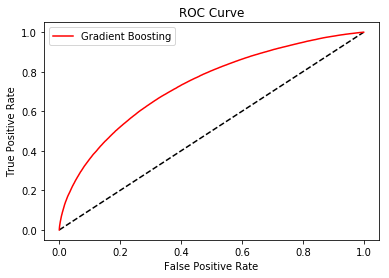

In [7]:
# Copy the parameter values that gives
# best accuracy from the randomized search.

parm_val = {'n_estimators': 1505, 'min_weight_fraction_leaf': 0.05,
            'min_samples_split': 1505, 'min_samples_leaf': 302,
            'max_features': 0.45, 'max_depth': 1002}

# Make a model
model = GradientBoostingClassifier(
        max_features=parm_val['max_features'],
        n_estimators=parm_val['n_estimators'],
        min_samples_leaf=parm_val['min_samples_leaf'],
        max_depth=parm_val['max_depth'],
        min_weight_fraction_leaf=parm_val['min_weight_fraction_leaf'],
        min_samples_split=parm_val['min_samples_split'],
        random_state=77)

# Fit the data.
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

# predicted value
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred,
                            target_names=['paid', 'not-paid']))

# Calculated probability
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Area under the curve.
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'r', label='Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [8]:
# Save the model for future use.

from joblib import dump, load
dump(model, 'Grad_boosting.joblib')

['Grad_boosting.joblib']